# Get data about Phase IDs and corresponding BBCH code

In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from agrotools import configs
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pylab import rcParams
from googletrans import Translator
from tqdm import tqdm

%matplotlib inline

In [2]:
prjconf = configs.ProjectConfigParser(config_file=None)

gis_raw = prjconf.get_path('GISdata', 'raw')
gis_dwd = prjconf.get_path('GISdata', 'dwd')

# Phenological Phase IDs

In [3]:
df_phaseid = pd.read_csv(Path(gis_dwd/'phenology'/'PH_Beschreibung_Phase.txt'), sep=';', encoding = 'ISO-8859-1')
print(df_phaseid.shape)
display(df_phaseid.head(1))
#delete last two columns and last raw
df_phaseid = df_phaseid.iloc[:-1,:-2]
display(df_phaseid.tail(3))
df_phaseid.to_csv(Path(gis_dwd/'phenology'/'DWD_Phenology__phase_ids.csv'), sep=';', encoding='utf8')

(50, 5)


,Phase_ID,Phase,Phase_englisch,eor,
0,1,Ergrünen Beginn,beginning of turning green,eor,...


,Phase_ID,Phase,Phase_englisch
46,65,Fahnenschieben Beginn,tip of tassel visible
47,66,Rispenschieben Beginn,beginning tassel emergence
48,67,Längenwachstum Beginn,beginning of growth in height


## Crop specific phase IDs

In [15]:
df_crop_phases = pd.read_csv(Path(gis_dwd/'phenology'/'PH_Beschreibung_Phasendefinition_Sofortmelder_Landwirtschaft_Kulturpflanze.txt'), sep=';', encoding = 'ISO-8859-1')
df_crop_phases = df_crop_phases.iloc[:-1,:-2]
print(df_crop_phases.shape)
display(df_crop_phases.head(1))
display(df_crop_phases.tail(1))

(72, 7)


,Objekt_id,Objekt,Phasen_id,Phase,Phasendefinition,BBCH_Code,Hinweis BBCH
0,201,Dauergrünland ...,35.0,1. Heu- oder (!) Silageschnitt,im Beobachtungsgebiet wird erstmals Grünland z...,,...


,Objekt_id,Objekt,Phasen_id,Phase,Phasendefinition,BBCH_Code,Hinweis BBCH
71,252,Futter-Rübe ...,24.0,Ernte,das beobachtete Feld wird abgeerntet ...,,...


In [18]:
trns = Translator()

df_crop_phases['Phase_en'] = ''
df_crop_phases['Phasendefinition_en'] = ''

for i, row in tqdm(df_crop_phases.iterrows()):
    df_crop_phases.loc[i, 'Phase_en'] = trns.translate(row.Phase, src='de', dest='en').text
    df_crop_phases.loc[i, 'Phasendefinition_en'] = trns.translate(row.Phasendefinition, src='de', dest='en').text
display(df_crop_phases.head(3))
print(df_crop_phases.shape)

72it [00:23,  3.07it/s]


,Objekt_id,Objekt,Phasen_id,Phase,Phasendefinition,BBCH_Code,Hinweis BBCH,Phase_en,Phasendefinition_en
0,201,Dauergrünland ...,35.0,1. Heu- oder (!) Silageschnitt,im Beobachtungsgebiet wird erstmals Grünland z...,,...,1. Hay or (!) Silage cut,"In the observation area, grassland is cut for ..."
1,201,Dauergrünland ...,27.0,2. Heuschnitt,im Beobachtungsgebiet wird zum zweiten Mal in ...,,...,2. Hay cut,"In the observation area, grassland is cut for ..."
2,201,Dauergrünland ...,1.0,Ergrünen Beginn,etwa 25% der ausgewählten Dauergrünlandfläche ...,,kein BBCH-Code vorhanden ...,Green start,about 25% of the selected permanent grassland ...


In [20]:
df_crop_phases.to_csv(Path(gis_dwd/'phenology'/'DWD_Phenology__crop_specific_phase_ids.csv'), sep=';', encoding='utf8')

# Phenological Stations

In [5]:
df_stations = pd.read_csv(Path(gis_dwd/'phenology'/'PH_Beschreibung_Phaenologie_Stationen_Sofortmelder.txt'), sep=';', encoding = 'ISO-8859-1')
df_stations = df_stations.iloc[:-1,:-2]
df_stations.columns = df_stations.columns.str.strip()
print(df_stations.shape)
display(df_stations.head(2))

(1185, 11)


,Stations_id,Stationsname,geograph.Breite,geograph.Laenge,Stationshoehe,Naturraumgruppe_Code,Naturraumgruppe,Naturraum_Code,Naturraum,Datum Stationsaufloesung,Bundesland
0,00140,Altmersleben,52.6861,11.4272,35.0,86.0,Altmark ...,8620.0,Stendaler Land ...,,Sachsen-Anhalt
1,00164,Angermünde,53.0316,13.9908,54.0,74.0,Rückland der Mecklenburgischen Seenplatte ...,7440.0,Uckermärkisches Hügelland (mit Uecker- und Ran...,,Brandenburg


### add GEOMETRY column

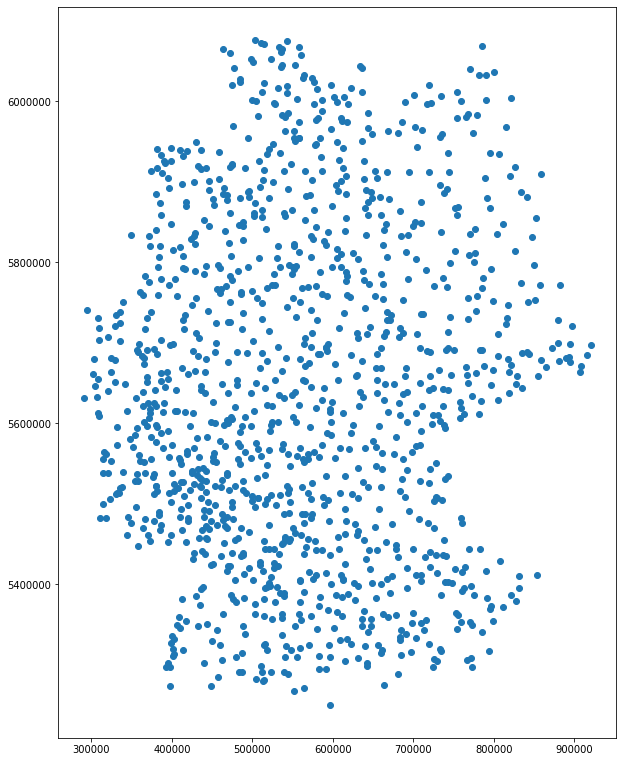

In [6]:
geometry = [Point(xy) for xy in zip(df_stations['geograph.Laenge'], df_stations['geograph.Breite'])]
crs = {'init': 'epsg:4326'}
df_gstations = gpd.GeoDataFrame(df_stations, crs=crs, geometry=geometry)
df_gstations = df_gstations.to_crs('EPSG:32632')
df_gstations.plot(figsize=(10,15))

In [10]:
df_gstations.to_file(Path(gis_dwd/'phenology'/'shp'/'DWD_Phenology__stations.geojson'), driver='GeoJSON')
df_gstations.to_csv(Path(gis_dwd/'phenology'/'DWD_Phenology__stations.csv'), sep=';', encoding='utf8')